In [1]:
!pip3 install facenet-pytorch torch torchvision scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.metrics import accuracy_score, classification_report
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.model_selection import train_test_split

/Users/soubhikghosh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/soubhikghosh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load FaceNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [4]:
# Initialize the MTCNN for face detection
mtcnn = MTCNN(device=device)

# Prepare the dataset (Using LFW as an example)
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
import torch
from torch.utils.data import DataLoader
from collections import Counter
from torchvision import datasets, transforms

# Assuming transform is already defined
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder('./data/lfw', transform=transform)

# Filter people with more than 1 image
class_counts = Counter(target for _, target in dataset)

# Filter classes where the count is more than 1
valid_classes = [class_idx for class_idx, count in class_counts.items() if count > 1]

# Create a filtered dataset with only the valid classes
filtered_samples = [(img, label) for img, label in dataset if label in valid_classes]

# Separate images and labels
images, labels = zip(*filtered_samples)

# Convert images and labels to tensors
images = torch.stack(images)
labels = torch.tensor(labels)

# Create the filtered dataset using TensorDataset
filtered_dataset = torch.utils.data.TensorDataset(images, labels)

# Prepare DataLoader for filtered dataset
data_loader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

# Prepare labels (class names)
class_names = [dataset.classes[i] for i in valid_classes]


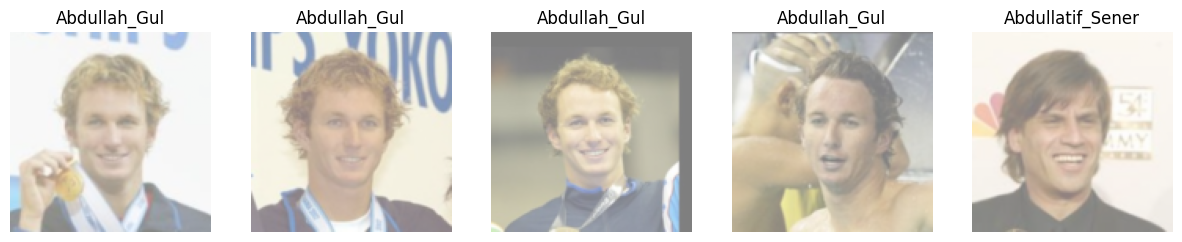

In [6]:
# Extract embeddings with progress bar
def extract_embeddings(data_loader, model, device):
    embeddings = []
    labels = []
    for images, targets in tqdm(data_loader, desc="Extracting embeddings"):
        images = images.to(device)
        with torch.no_grad():
            emb = model(images).cpu().numpy()
        embeddings.extend(emb)
        labels.extend(targets.numpy())
    return np.array(embeddings), np.array(labels)

# Visualize sample faces and labels
def visualize_samples(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, (img, label) in enumerate(dataset):
        if i == 5:
            break
        axes[i].imshow(np.transpose((img.numpy() * 0.5 + 0.5), (1, 2, 0)))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.show()

visualize_samples(filtered_dataset)

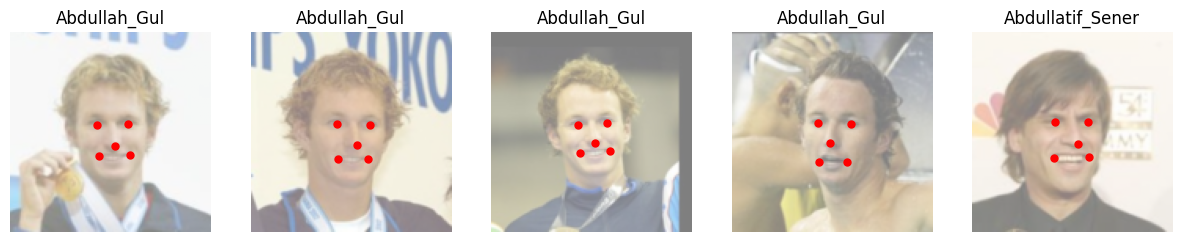

In [7]:
# Visualize face landmarks on images
def visualize_landmarks(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    for i, (img, label) in enumerate(dataset):
        if i == 5:
            break

        # Convert image to tensor and detect faces and landmarks
        img_pil = transforms.ToPILImage()(img)  # Convert to PIL for MTCNN processing
        boxes, probs, landmarks = mtcnn.detect(img_pil, landmarks=True)  # Detect face and landmarks

        if boxes is not None:
            axes[i].imshow(np.transpose((img.numpy() * 0.5 + 0.5), (1, 2, 0)))
            
            # Plot the landmarks (5 keypoints: eyes, nose, mouth corners)
            for landmark in landmarks[0]:
                axes[i].plot(landmark[0], landmark[1], 'ro', markersize=5)  # 'ro' means red circles
                
            axes[i].set_title(f"{class_names[label]}")
            axes[i].axis('off')
    
    plt.show()

# Visualize the first few images with landmarks detected
visualize_landmarks(filtered_samples)

In [8]:
# Extract embeddings
embeddings, labels = extract_embeddings(data_loader, model, device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

Extracting embeddings: 100%|██████████| 287/287 [09:14<00:00,  1.93s/it]


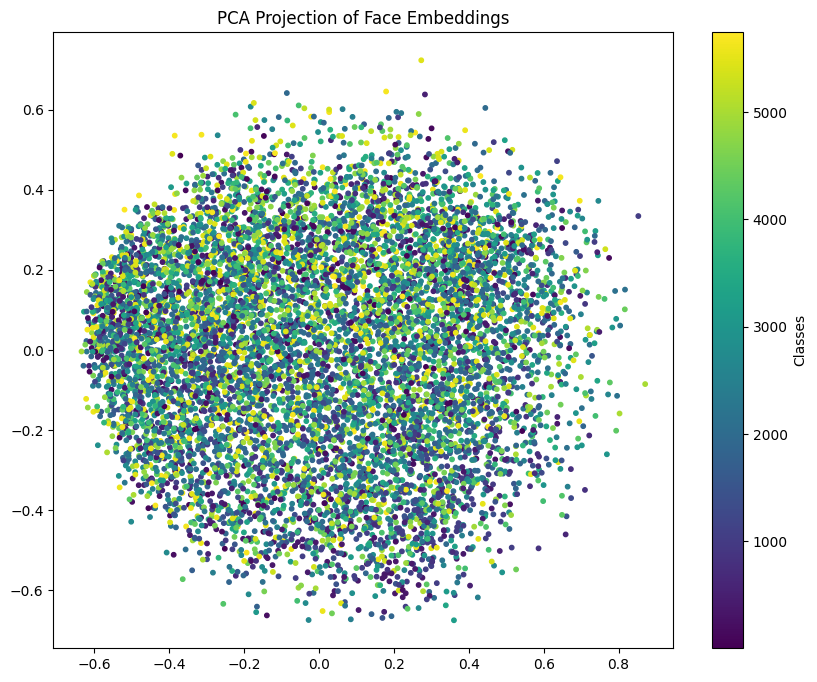

In [9]:
# Visualize embeddings using PCA
def visualize_embeddings(embeddings, labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label="Classes")
    plt.title("PCA Projection of Face Embeddings")
    plt.show()

visualize_embeddings(embeddings, labels)


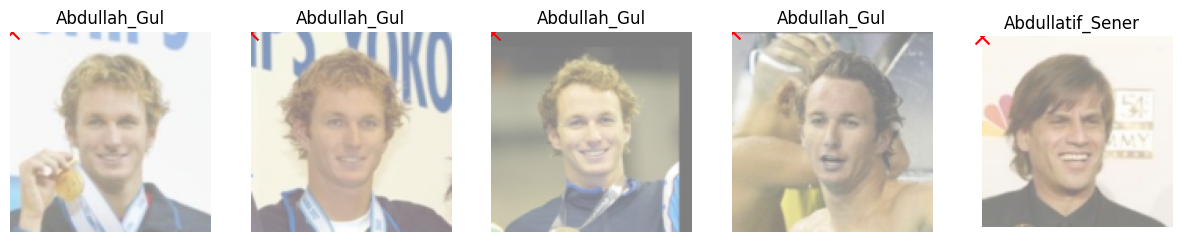

In [10]:
def visualize_samples_with_embeddings(dataset, embeddings):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embeddings)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, (img, label) in enumerate(dataset):
        if i == 5:
            break

        # Get the PCA projection for this sample
        pca_x, pca_y = reduced_data[i]

        # Plot the image
        axes[i].imshow(np.transpose((img.numpy() * 0.5 + 0.5), (1, 2, 0)))
        axes[i].set_title(f"{class_names[label]}")

        # Overlay the PCA projection (embedding) as a point
        axes[i].scatter(pca_x, pca_y, color='red', marker='x', s=100, label="Embedding")
        axes[i].axis('off')
    
    plt.show()

visualize_samples_with_embeddings(filtered_samples, embeddings)


In [11]:
# Train a classifier on the embeddings
from sklearn.svm import SVC
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [12]:
# Predict on the test set
y_pred = classifier.predict(X_test)

y_test


array([ 754, 5441, 2783, ..., 1404,  531, 2163])

In [13]:
y_pred

array([2506, 1871, 2828, ..., 1871,  531, 2163])

In [14]:
# Calculate accuracy and display a classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 27.39%


ValueError: The number of FixedLocator locations (892), usually from a call to set_ticks, does not match the number of labels (1680).

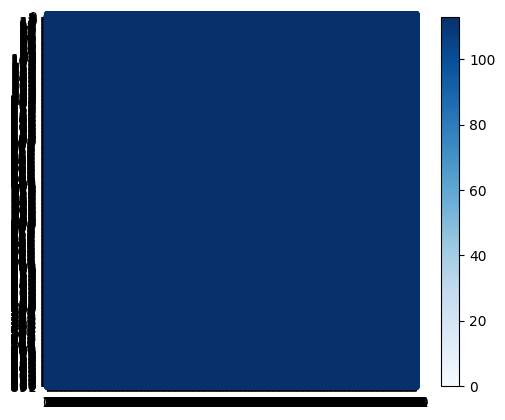

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with corrected class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

